## Import packages you need


In [1]:
# Import necessary packages.
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, SubsetRandomSampler
from torchvision.datasets import DatasetFolder
from sklearn.model_selection import KFold

# If you haven't download the tqdm package, just uncomment the following line.
#!pip install tqdm
# This is for the progress bar.
from tqdm.auto import tqdm


/home/alex/miniconda3/envs/4016/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Show current device name


In [2]:
torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 3080 Ti'

## Dataset, Data Loader, and Transforms



In [3]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),

    # Randomly flip and rotate the image
    transforms.RandomRotation(degrees=10),
    transforms.RandomChoice([
        transforms.RandomVerticalFlip(p=0.8),
        transforms.RandomHorizontalFlip(p=0.8),
    ]),

    # Randomly crop a portion of the image
    transforms.RandomChoice([
        transforms.RandomCrop(size=128, padding=10),
        transforms.RandomResizedCrop(size=128, scale=(0.7, 1.3)),
    ]),

    # Randomly adjust the brightness and contrast of the image
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.5),
        transforms.ColorJitter(contrast=0.5),
    ]),

    # Convert the image to a tensor
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 64

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("../data/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("../data/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("../data/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("../data/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


## Model

model = torchvision.models.resnet18(pretrained=False) → This is fine.

model = torchvision.models.resnet18(pretrained=True) → This is NOT allowed.


## Training


In [4]:
def get_pseudo_labels(dataset, model, threshold=0.65):
    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    # Iterate over the dataset by batches.
    for batch in tqdm(dataloader):
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)

        # you may filter the data and construct a new dataset here.

    # # Turn off the eval mode.
    model.train()
    return dataset


In [ ]:
def model_snapshot(model, new_file=None, old_file=None):
    if os.path.exists(old_file) is True:
        os.remove(old_file)
    torch.save(model, new_file)

In [5]:
def trainModel(model, n_epochs, do_semi, device, criterion, optimizer, train_loader, valid_loader):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    bestAcc = 0.
    bestEpoch = 0

    for epoch in range(n_epochs):
        # ---------- TODO ----------
        # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
        # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
        if do_semi:
            # Obtain pseudo-labels for unlabeled data using trained model.
            pseudo_set = get_pseudo_labels(unlabeled_set, model)

            # Construct a new dataset and a data loader for training.
            # This is used in semi-supervised learning only.
            concat_dataset = ConcatDataset([train_set, pseudo_set])
            train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        # Iterate the training set by batches.
        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(device))

            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(device))

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)

        # The average loss and accuracy of the training set is the average of the recorded values.
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        # Print the information.
        print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in tqdm(valid_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(device))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        # Print the information.
        print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

        # Save the loss and accuracy for each epoch.
        history['train_loss'].append(train_loss)
        history['val_loss'].append(valid_loss)
        history['train_acc'].append(train_acc.cpu())
        history['val_acc'].append(valid_acc.cpu())
        
        if valid_acc > bestAcc:
            model_snapshot(model.state_dict(), new_file=f"{epoch}_{valid_acc}.pth", old_file=f"{bestEpoch}_{bestAcc}.pth")
            bestAcc = valid_acc
            bestEpoch = epoch

    # Return model and history for later use.
    return model, history


In [57]:
def plotLoss(history, n_epochs):
    plt.plot([*range(1, n_epochs+1)], history['train_loss'])
    plt.plot([*range(1, n_epochs+1)], history['val_loss'])
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.legend(labels=['Train', 'Validation'])


In [58]:
def plotAcc(history, n_epochs):
    plt.plot([*range(1, n_epochs+1)], history['train_acc'])
    plt.plot([*range(1, n_epochs+1)], history['val_acc'])
    plt.xlabel("Epoches")
    plt.ylabel("Accuracy")
    plt.legend(labels=['Train', 'Validation'])


In [7]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = Classifier().to(device)
model = torchvision.models.efficientnet_b6().to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 200

# Whether to do semi-supervised learning.
do_semi = False


In [8]:
trainedModel, history = trainModel(model, n_epochs, do_semi, device, criterion, optimizer, train_loader, valid_loader)


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 001/200 ] loss = 6.06413, acc = 0.07951


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 001/200 ] loss = 5.87021, acc = 0.09148


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 002/200 ] loss = 3.40107, acc = 0.09236


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 002/200 ] loss = 5.06109, acc = 0.09460


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 003/200 ] loss = 2.60765, acc = 0.09792


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 003/200 ] loss = 4.01927, acc = 0.08523


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 004/200 ] loss = 2.53144, acc = 0.10847


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 004/200 ] loss = 2.98414, acc = 0.10398


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 005/200 ] loss = 2.46346, acc = 0.11403


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 005/200 ] loss = 2.69532, acc = 0.08523


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 006/200 ] loss = 2.41418, acc = 0.11528


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 006/200 ] loss = 2.57897, acc = 0.09148


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 007/200 ] loss = 2.36507, acc = 0.11972


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 007/200 ] loss = 2.51420, acc = 0.08835


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 008/200 ] loss = 2.33687, acc = 0.12458


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 008/200 ] loss = 2.48360, acc = 0.09773


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 009/200 ] loss = 2.30909, acc = 0.14417


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 009/200 ] loss = 2.47157, acc = 0.08835


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 010/200 ] loss = 2.28396, acc = 0.15118


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 010/200 ] loss = 2.45872, acc = 0.09773


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 011/200 ] loss = 2.25750, acc = 0.16347


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 011/200 ] loss = 2.45694, acc = 0.09773


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 012/200 ] loss = 2.23780, acc = 0.17007


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 012/200 ] loss = 2.45167, acc = 0.09460


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 013/200 ] loss = 2.24213, acc = 0.16521


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 013/200 ] loss = 2.42601, acc = 0.08949


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 014/200 ] loss = 2.19849, acc = 0.19243


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 014/200 ] loss = 2.34527, acc = 0.11733


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 015/200 ] loss = 2.21512, acc = 0.17708


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 015/200 ] loss = 2.30071, acc = 0.16960


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 016/200 ] loss = 2.18391, acc = 0.18799


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 016/200 ] loss = 2.19859, acc = 0.20824


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 017/200 ] loss = 2.16718, acc = 0.19979


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 017/200 ] loss = 2.21340, acc = 0.21477


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 018/200 ] loss = 2.11943, acc = 0.21736


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 018/200 ] loss = 2.07011, acc = 0.25313


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 019/200 ] loss = 2.11669, acc = 0.22729


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 019/200 ] loss = 2.17828, acc = 0.19261


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 020/200 ] loss = 2.09581, acc = 0.24229


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 020/200 ] loss = 2.18380, acc = 0.22273


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 021/200 ] loss = 2.08604, acc = 0.23410


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 021/200 ] loss = 2.13317, acc = 0.25568


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 022/200 ] loss = 2.05712, acc = 0.25042


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 022/200 ] loss = 2.04839, acc = 0.26364


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 023/200 ] loss = 2.05890, acc = 0.24514


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 023/200 ] loss = 2.01442, acc = 0.24517


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 024/200 ] loss = 2.04051, acc = 0.25646


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 024/200 ] loss = 2.21941, acc = 0.24716


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 025/200 ] loss = 2.00178, acc = 0.28063


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 025/200 ] loss = 2.08570, acc = 0.23551


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 026/200 ] loss = 2.00915, acc = 0.26569


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 026/200 ] loss = 1.98134, acc = 0.31875


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 027/200 ] loss = 1.98757, acc = 0.27701


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 027/200 ] loss = 1.99460, acc = 0.32898


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 028/200 ] loss = 1.97295, acc = 0.30042


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 028/200 ] loss = 1.98353, acc = 0.32358


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 029/200 ] loss = 1.97027, acc = 0.29681


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 029/200 ] loss = 2.12227, acc = 0.29915


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 030/200 ] loss = 1.95710, acc = 0.30354


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 030/200 ] loss = 2.00209, acc = 0.28835


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 031/200 ] loss = 1.96326, acc = 0.31465


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 031/200 ] loss = 2.26208, acc = 0.25682


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 032/200 ] loss = 1.89970, acc = 0.33562


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 032/200 ] loss = 2.02389, acc = 0.31335


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 033/200 ] loss = 1.87240, acc = 0.33215


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 033/200 ] loss = 2.02980, acc = 0.26676


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 034/200 ] loss = 1.87981, acc = 0.33583


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 034/200 ] loss = 1.92780, acc = 0.32614


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 035/200 ] loss = 1.86772, acc = 0.33569


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 035/200 ] loss = 1.84328, acc = 0.35085


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 036/200 ] loss = 1.83986, acc = 0.34611


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 036/200 ] loss = 1.82307, acc = 0.35653


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 037/200 ] loss = 1.79559, acc = 0.35326


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 037/200 ] loss = 1.96447, acc = 0.32812


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 038/200 ] loss = 1.81004, acc = 0.35979


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 038/200 ] loss = 2.03882, acc = 0.29403


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 039/200 ] loss = 1.78708, acc = 0.37042


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 039/200 ] loss = 1.90373, acc = 0.36562


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 040/200 ] loss = 1.75382, acc = 0.38875


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 040/200 ] loss = 1.72713, acc = 0.38977


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 041/200 ] loss = 1.71733, acc = 0.38910


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 041/200 ] loss = 1.77125, acc = 0.38892


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 042/200 ] loss = 1.74211, acc = 0.39854


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 042/200 ] loss = 1.66596, acc = 0.40739


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 043/200 ] loss = 1.69341, acc = 0.41181


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 043/200 ] loss = 1.81401, acc = 0.36818


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 044/200 ] loss = 1.65319, acc = 0.40854


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 044/200 ] loss = 1.77651, acc = 0.37131


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 045/200 ] loss = 1.64890, acc = 0.42049


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 045/200 ] loss = 1.74269, acc = 0.40170


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 046/200 ] loss = 1.61873, acc = 0.42681


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 046/200 ] loss = 1.99040, acc = 0.39659


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 047/200 ] loss = 1.60671, acc = 0.43757


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 047/200 ] loss = 1.67682, acc = 0.42244


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 048/200 ] loss = 1.57199, acc = 0.44715


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 048/200 ] loss = 1.67046, acc = 0.41733


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 049/200 ] loss = 1.56089, acc = 0.44854


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 049/200 ] loss = 1.59883, acc = 0.42784


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 050/200 ] loss = 1.55044, acc = 0.45229


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 050/200 ] loss = 1.51791, acc = 0.49631


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 051/200 ] loss = 1.50932, acc = 0.46764


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 051/200 ] loss = 1.85364, acc = 0.42244


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 052/200 ] loss = 1.49378, acc = 0.47451


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 052/200 ] loss = 1.59519, acc = 0.48239


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 053/200 ] loss = 1.51235, acc = 0.46639


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 053/200 ] loss = 1.60632, acc = 0.46903


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 054/200 ] loss = 1.40481, acc = 0.51104


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 054/200 ] loss = 1.56223, acc = 0.48295


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 055/200 ] loss = 1.49318, acc = 0.47194


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 055/200 ] loss = 1.62576, acc = 0.47074


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 056/200 ] loss = 1.44947, acc = 0.49458


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 056/200 ] loss = 1.63049, acc = 0.45881


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 057/200 ] loss = 1.40159, acc = 0.51708


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 057/200 ] loss = 1.57847, acc = 0.48438


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 058/200 ] loss = 1.37308, acc = 0.52736


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 058/200 ] loss = 1.43535, acc = 0.52472


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 059/200 ] loss = 1.34871, acc = 0.52597


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 059/200 ] loss = 1.50620, acc = 0.48011


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 060/200 ] loss = 1.34253, acc = 0.54222


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 060/200 ] loss = 1.50525, acc = 0.49687


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 061/200 ] loss = 1.30510, acc = 0.55014


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 061/200 ] loss = 1.59014, acc = 0.48494


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 062/200 ] loss = 1.30299, acc = 0.55569


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 062/200 ] loss = 1.42198, acc = 0.50597


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 063/200 ] loss = 1.25382, acc = 0.57111


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 063/200 ] loss = 1.49419, acc = 0.51222


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 064/200 ] loss = 1.26531, acc = 0.57174


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 064/200 ] loss = 1.48686, acc = 0.50000


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 065/200 ] loss = 1.27235, acc = 0.56458


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 065/200 ] loss = 1.44502, acc = 0.52955


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 066/200 ] loss = 1.22453, acc = 0.58444


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 066/200 ] loss = 1.57194, acc = 0.48267


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 067/200 ] loss = 1.17843, acc = 0.59528


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 067/200 ] loss = 1.42163, acc = 0.51619


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 068/200 ] loss = 1.15602, acc = 0.60125


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 068/200 ] loss = 1.43167, acc = 0.53551


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 069/200 ] loss = 1.18042, acc = 0.60014


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 069/200 ] loss = 1.55402, acc = 0.50710


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 070/200 ] loss = 1.14582, acc = 0.60840


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 070/200 ] loss = 1.57280, acc = 0.53693


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 071/200 ] loss = 1.13911, acc = 0.60111


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 071/200 ] loss = 1.50373, acc = 0.50284


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 072/200 ] loss = 1.12743, acc = 0.61111


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 072/200 ] loss = 1.44853, acc = 0.53580


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 073/200 ] loss = 1.07659, acc = 0.61882


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 073/200 ] loss = 1.38108, acc = 0.53324


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 074/200 ] loss = 1.06734, acc = 0.64271


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 074/200 ] loss = 1.73136, acc = 0.52216


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 075/200 ] loss = 1.02524, acc = 0.65333


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 075/200 ] loss = 1.39229, acc = 0.55540


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 076/200 ] loss = 1.05719, acc = 0.64083


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 076/200 ] loss = 1.34181, acc = 0.57841


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 077/200 ] loss = 1.04520, acc = 0.64076


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 077/200 ] loss = 1.37339, acc = 0.55625


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 078/200 ] loss = 1.00249, acc = 0.65868


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 078/200 ] loss = 1.42335, acc = 0.57926


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 079/200 ] loss = 0.97123, acc = 0.67854


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 079/200 ] loss = 1.46738, acc = 0.55937


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 080/200 ] loss = 0.90865, acc = 0.69563


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 080/200 ] loss = 1.50899, acc = 0.53693


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 081/200 ] loss = 0.92520, acc = 0.69160


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 081/200 ] loss = 1.34580, acc = 0.57017


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 082/200 ] loss = 0.91714, acc = 0.68278


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 082/200 ] loss = 1.50089, acc = 0.55881


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 083/200 ] loss = 0.92568, acc = 0.68799


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 083/200 ] loss = 1.55308, acc = 0.53466


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 084/200 ] loss = 0.90176, acc = 0.70090


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 084/200 ] loss = 1.37961, acc = 0.59062


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 085/200 ] loss = 0.85466, acc = 0.70993


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 085/200 ] loss = 1.43150, acc = 0.56193


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 086/200 ] loss = 0.85933, acc = 0.70708


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 086/200 ] loss = 1.40980, acc = 0.56449


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 087/200 ] loss = 0.84098, acc = 0.71840


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 087/200 ] loss = 1.53489, acc = 0.58466


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 088/200 ] loss = 0.78599, acc = 0.73854


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 088/200 ] loss = 1.36806, acc = 0.59489


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 089/200 ] loss = 0.81286, acc = 0.71861


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 089/200 ] loss = 1.41184, acc = 0.58182


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 090/200 ] loss = 0.78295, acc = 0.74250


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 090/200 ] loss = 1.41174, acc = 0.59034


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 091/200 ] loss = 0.75881, acc = 0.74111


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 091/200 ] loss = 1.53998, acc = 0.54233


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 092/200 ] loss = 0.74238, acc = 0.74632


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 092/200 ] loss = 1.70089, acc = 0.55313


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 093/200 ] loss = 0.70737, acc = 0.76444


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 093/200 ] loss = 1.40545, acc = 0.61705


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 094/200 ] loss = 0.73267, acc = 0.75076


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 094/200 ] loss = 1.48650, acc = 0.56818


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 095/200 ] loss = 0.70680, acc = 0.76257


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 095/200 ] loss = 1.49614, acc = 0.55909


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 096/200 ] loss = 0.69404, acc = 0.75861


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 096/200 ] loss = 1.41814, acc = 0.60341


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 097/200 ] loss = 0.65565, acc = 0.77264


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 097/200 ] loss = 1.46374, acc = 0.59432


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 098/200 ] loss = 0.66067, acc = 0.78646


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 098/200 ] loss = 1.51931, acc = 0.57102


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 099/200 ] loss = 0.63758, acc = 0.78257


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 099/200 ] loss = 1.52622, acc = 0.60313


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 100/200 ] loss = 0.64410, acc = 0.79167


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 100/200 ] loss = 1.42766, acc = 0.58750


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 101/200 ] loss = 0.61992, acc = 0.79361


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 101/200 ] loss = 1.44317, acc = 0.58040


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 102/200 ] loss = 0.60479, acc = 0.79986


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 102/200 ] loss = 1.43329, acc = 0.59943


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 103/200 ] loss = 0.59129, acc = 0.79160


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 103/200 ] loss = 1.69163, acc = 0.57330


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 104/200 ] loss = 0.57341, acc = 0.81299


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 104/200 ] loss = 1.47365, acc = 0.56989


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 105/200 ] loss = 0.56977, acc = 0.80201


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 105/200 ] loss = 1.39261, acc = 0.61307


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 106/200 ] loss = 0.58120, acc = 0.80097


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 106/200 ] loss = 1.53619, acc = 0.58892


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 107/200 ] loss = 0.56788, acc = 0.81153


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 107/200 ] loss = 1.54547, acc = 0.57244


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 108/200 ] loss = 0.54950, acc = 0.81778


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 108/200 ] loss = 1.53725, acc = 0.61108


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 109/200 ] loss = 0.53802, acc = 0.82111


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 109/200 ] loss = 1.41522, acc = 0.62784


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 110/200 ] loss = 0.50160, acc = 0.82910


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 110/200 ] loss = 1.62421, acc = 0.56591


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 111/200 ] loss = 0.53661, acc = 0.81646


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 111/200 ] loss = 1.46731, acc = 0.60142


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 112/200 ] loss = 0.49714, acc = 0.83382


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 112/200 ] loss = 1.64588, acc = 0.59744


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 113/200 ] loss = 0.42097, acc = 0.85063


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 113/200 ] loss = 1.59739, acc = 0.60284


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 114/200 ] loss = 0.54159, acc = 0.82340


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 114/200 ] loss = 1.58678, acc = 0.61903


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 115/200 ] loss = 0.45601, acc = 0.85090


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 115/200 ] loss = 1.83845, acc = 0.55568


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 116/200 ] loss = 0.44383, acc = 0.84896


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 116/200 ] loss = 1.40359, acc = 0.61392


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 117/200 ] loss = 0.45933, acc = 0.84375


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 117/200 ] loss = 1.62087, acc = 0.58324


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 118/200 ] loss = 0.47676, acc = 0.84972


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 118/200 ] loss = 1.61154, acc = 0.61506


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 119/200 ] loss = 0.41269, acc = 0.86097


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 119/200 ] loss = 1.66722, acc = 0.58125


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 120/200 ] loss = 0.43509, acc = 0.85743


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 120/200 ] loss = 1.44044, acc = 0.63097


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 121/200 ] loss = 0.42889, acc = 0.85431


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 121/200 ] loss = 1.64742, acc = 0.60994


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 122/200 ] loss = 0.39507, acc = 0.87125


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 122/200 ] loss = 1.61888, acc = 0.60000


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 123/200 ] loss = 0.39803, acc = 0.86694


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 123/200 ] loss = 1.79561, acc = 0.57188


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 124/200 ] loss = 0.39151, acc = 0.87181


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 124/200 ] loss = 1.65606, acc = 0.59403


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 125/200 ] loss = 0.35805, acc = 0.87194


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 125/200 ] loss = 1.81300, acc = 0.56903


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 126/200 ] loss = 0.41019, acc = 0.85875


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 126/200 ] loss = 1.88895, acc = 0.58210


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 127/200 ] loss = 0.35132, acc = 0.88514


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 127/200 ] loss = 1.56684, acc = 0.63381


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 128/200 ] loss = 0.35319, acc = 0.88056


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 128/200 ] loss = 1.68648, acc = 0.60795


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 129/200 ] loss = 0.35520, acc = 0.88201


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 129/200 ] loss = 1.51156, acc = 0.62159


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 130/200 ] loss = 0.37246, acc = 0.87750


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 130/200 ] loss = 1.49237, acc = 0.61676


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 131/200 ] loss = 0.37113, acc = 0.88271


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 131/200 ] loss = 1.65765, acc = 0.58977


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 132/200 ] loss = 0.37448, acc = 0.88431


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 132/200 ] loss = 1.52488, acc = 0.64915


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 133/200 ] loss = 0.33120, acc = 0.88708


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 133/200 ] loss = 1.58544, acc = 0.61676


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 134/200 ] loss = 0.34781, acc = 0.88708


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 134/200 ] loss = 1.61764, acc = 0.63381


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 135/200 ] loss = 0.34075, acc = 0.87771


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 135/200 ] loss = 1.59235, acc = 0.63040


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 136/200 ] loss = 0.37598, acc = 0.87597


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 136/200 ] loss = 1.66709, acc = 0.61392


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 137/200 ] loss = 0.33153, acc = 0.88826


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 137/200 ] loss = 1.50778, acc = 0.62926


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 138/200 ] loss = 0.34177, acc = 0.88618


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 138/200 ] loss = 1.74062, acc = 0.62131


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 139/200 ] loss = 0.34991, acc = 0.88243


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 139/200 ] loss = 1.84001, acc = 0.56051


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 140/200 ] loss = 0.28379, acc = 0.90611


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 140/200 ] loss = 1.88564, acc = 0.57102


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 141/200 ] loss = 0.27772, acc = 0.90181


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 141/200 ] loss = 1.73493, acc = 0.60540


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 142/200 ] loss = 0.29142, acc = 0.90264


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 142/200 ] loss = 1.89127, acc = 0.57812


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 143/200 ] loss = 0.31963, acc = 0.89368


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 143/200 ] loss = 1.68033, acc = 0.61193


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 144/200 ] loss = 0.33939, acc = 0.89514


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 144/200 ] loss = 1.64110, acc = 0.62244


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 145/200 ] loss = 0.29044, acc = 0.91035


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 145/200 ] loss = 1.60346, acc = 0.63778


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 146/200 ] loss = 0.27393, acc = 0.91049


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 146/200 ] loss = 1.77003, acc = 0.63125


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 147/200 ] loss = 0.33445, acc = 0.88458


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 147/200 ] loss = 1.93478, acc = 0.60881


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 148/200 ] loss = 0.30097, acc = 0.89576


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 148/200 ] loss = 1.70191, acc = 0.63040


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 149/200 ] loss = 0.29650, acc = 0.90458


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 149/200 ] loss = 1.88589, acc = 0.60511


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 150/200 ] loss = 0.26018, acc = 0.91847


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 150/200 ] loss = 1.64287, acc = 0.60824


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 151/200 ] loss = 0.29947, acc = 0.90438


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 151/200 ] loss = 1.68023, acc = 0.62983


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 152/200 ] loss = 0.28793, acc = 0.91188


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 152/200 ] loss = 1.51141, acc = 0.64858


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 153/200 ] loss = 0.26396, acc = 0.90993


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 153/200 ] loss = 1.58137, acc = 0.66222


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 154/200 ] loss = 0.25437, acc = 0.91590


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 154/200 ] loss = 1.64600, acc = 0.62841


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 155/200 ] loss = 0.28629, acc = 0.91257


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 155/200 ] loss = 1.81225, acc = 0.62273


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 156/200 ] loss = 0.25109, acc = 0.91792


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 156/200 ] loss = 1.59316, acc = 0.63409


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 157/200 ] loss = 0.26513, acc = 0.91056


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 157/200 ] loss = 1.79809, acc = 0.62500


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 158/200 ] loss = 0.23777, acc = 0.92313


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 158/200 ] loss = 1.76677, acc = 0.62955


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 159/200 ] loss = 0.25571, acc = 0.91104


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 159/200 ] loss = 1.67691, acc = 0.65739


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 160/200 ] loss = 0.24209, acc = 0.91660


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 160/200 ] loss = 1.67860, acc = 0.62955


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 161/200 ] loss = 0.21509, acc = 0.92563


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 161/200 ] loss = 1.66704, acc = 0.64830


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 162/200 ] loss = 0.27078, acc = 0.91465


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 162/200 ] loss = 1.80489, acc = 0.62500


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 163/200 ] loss = 0.25043, acc = 0.91403


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 163/200 ] loss = 1.71021, acc = 0.62472


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 164/200 ] loss = 0.20592, acc = 0.93042


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 164/200 ] loss = 1.61222, acc = 0.64091


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 165/200 ] loss = 0.25027, acc = 0.91646


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 165/200 ] loss = 1.78284, acc = 0.61761


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 166/200 ] loss = 0.22663, acc = 0.92486


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 166/200 ] loss = 1.71214, acc = 0.67500


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 167/200 ] loss = 0.23190, acc = 0.92646


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 167/200 ] loss = 1.68290, acc = 0.60795


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 168/200 ] loss = 0.24922, acc = 0.91771


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 168/200 ] loss = 1.72651, acc = 0.62472


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 169/200 ] loss = 0.23510, acc = 0.92028


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 169/200 ] loss = 1.65076, acc = 0.63892


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 170/200 ] loss = 0.20106, acc = 0.92944


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 170/200 ] loss = 1.74628, acc = 0.62216


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 171/200 ] loss = 0.24657, acc = 0.91604


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 171/200 ] loss = 1.74997, acc = 0.62045


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 172/200 ] loss = 0.22732, acc = 0.93014


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 172/200 ] loss = 1.57182, acc = 0.65909


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 173/200 ] loss = 0.19666, acc = 0.93424


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 173/200 ] loss = 1.78183, acc = 0.61619


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 174/200 ] loss = 0.23648, acc = 0.92556


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 174/200 ] loss = 1.55822, acc = 0.62756


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 175/200 ] loss = 0.18007, acc = 0.94847


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 175/200 ] loss = 1.60672, acc = 0.64489


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 176/200 ] loss = 0.22719, acc = 0.93340


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 176/200 ] loss = 1.89093, acc = 0.61080


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 177/200 ] loss = 0.20351, acc = 0.92993


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 177/200 ] loss = 1.91191, acc = 0.59744


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 178/200 ] loss = 0.19840, acc = 0.93493


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 178/200 ] loss = 1.77878, acc = 0.63239


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 179/200 ] loss = 0.21850, acc = 0.92993


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 179/200 ] loss = 1.87885, acc = 0.59119


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 180/200 ] loss = 0.19978, acc = 0.93396


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 180/200 ] loss = 1.84259, acc = 0.59290


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 181/200 ] loss = 0.17642, acc = 0.93944


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 181/200 ] loss = 1.70529, acc = 0.63295


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 182/200 ] loss = 0.17951, acc = 0.93861


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 182/200 ] loss = 1.70365, acc = 0.64403


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 183/200 ] loss = 0.18747, acc = 0.93292


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 183/200 ] loss = 1.61272, acc = 0.63097


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 184/200 ] loss = 0.21193, acc = 0.92785


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 184/200 ] loss = 1.80855, acc = 0.62869


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 185/200 ] loss = 0.20151, acc = 0.93653


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 185/200 ] loss = 1.55049, acc = 0.66591


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 186/200 ] loss = 0.20445, acc = 0.93708


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 186/200 ] loss = 1.88215, acc = 0.62216


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 187/200 ] loss = 0.16909, acc = 0.94757


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 187/200 ] loss = 1.72318, acc = 0.64148


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 188/200 ] loss = 0.22207, acc = 0.92736


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 188/200 ] loss = 1.89984, acc = 0.61563


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 189/200 ] loss = 0.20371, acc = 0.93083


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 189/200 ] loss = 1.85516, acc = 0.64773


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 190/200 ] loss = 0.17885, acc = 0.94313


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 190/200 ] loss = 1.81081, acc = 0.64688


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 191/200 ] loss = 0.18305, acc = 0.94243


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 191/200 ] loss = 1.74357, acc = 0.64034


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 192/200 ] loss = 0.16271, acc = 0.94514


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 192/200 ] loss = 2.00799, acc = 0.61165


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 193/200 ] loss = 0.19582, acc = 0.93896


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 193/200 ] loss = 1.70571, acc = 0.65767


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 194/200 ] loss = 0.19222, acc = 0.94035


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 194/200 ] loss = 1.95685, acc = 0.57756


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 195/200 ] loss = 0.20448, acc = 0.92743


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 195/200 ] loss = 1.68350, acc = 0.63551


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 196/200 ] loss = 0.17102, acc = 0.94438


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 196/200 ] loss = 1.67148, acc = 0.65625


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 197/200 ] loss = 0.19418, acc = 0.94368


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 197/200 ] loss = 1.94309, acc = 0.63267


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 198/200 ] loss = 0.18700, acc = 0.93813


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 198/200 ] loss = 1.85701, acc = 0.62955


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 199/200 ] loss = 0.18408, acc = 0.94396


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 199/200 ] loss = 1.66957, acc = 0.65341


  0%|          | 0/45 [00:00<?, ?it/s]

[ Train | 200/200 ] loss = 0.15361, acc = 0.95132


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 200/200 ] loss = 1.62240, acc = 0.65881


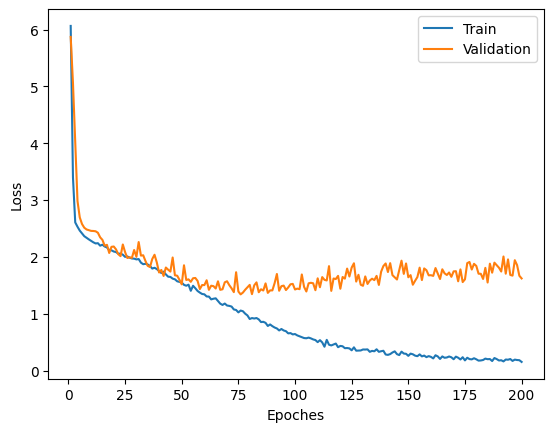

In [55]:
plotLoss(history, n_epochs)


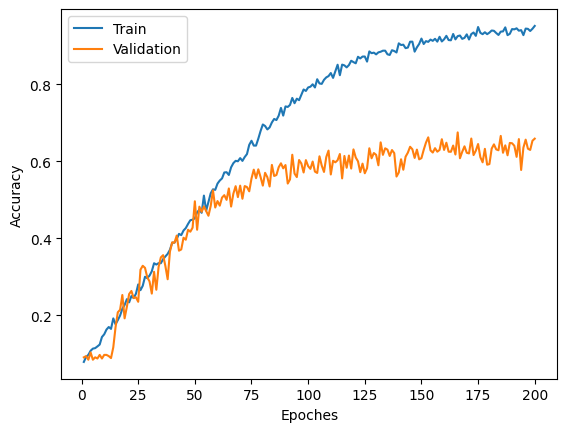

In [56]:
plotAcc(history, n_epochs)


## Testing


In [10]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())


  0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")


## Hints for better result

-   Design a better architecture
-   Adopt different data augmentations to improve the performance.
-   Utilize provided unlabeled data in training set
